# Introduction to DSC

In this tutorial, you will get acquainted with the basic features of DSC through a very simple example. You are encouraged to [install DSC](../installation.html) and try running the DSC example on your computer.

## Overview

Suppose we want to compare several methods for a particular inference task, denoted by $I$. For example, $I$ could be:

+ Predict the missing entries of a matrix;

+ Estimate a covariance matrix from a data sample; 

+ Estimate a regression function relating outcome $Y$ to covariates (features) $X$.

For these three tasks, and others, we could conduct a benchmarking experiment to compare methods to perform $I$ by repeating the following three steps:

  1. Simulate some data suitable for performing $I$.
  
  2. Analyze the data with a method designed to perform $I$.
  
  3. Score how well the method performed $I$ (e.g., by comparing the methods' estimates against the ground-truth provided by the simulation).

DSC can handle more complex settings than this, but this basic structure suffices to explain the key concepts. We call this basic structure the "simulate-analyze-score" design pattern.

### DSC modules, groups, and pipelines

Typically we will want to try different ways of implementating steps 1–3; that is, different ways to simulate the data, different ways to analyze the data, and different ways to score how well a method performed. 

In DSC, each different way of implementing a step is expressed as a "module", and then a "group of modules" defines the collection of alternative approaches.

In our example, we define:

1. A group of `simulate` modules, each of which can perform step 1;

2. A group of `analyze` modules, each of which can perform step 2; and 

3. A group of `score` modules, each of which can perform step 3. 

Running the benchmark then consists of running sequences of modules—what we call "pipelines"—and each pipeline invokes one module from the `simulate` group, followed by a module from the `analyze` group, and then a module from the `score` group.

DSC provides a flexible and easy-to-use language to manage and run benchmarks like these, as well as more complex ones. The modular design makes it easy to extend benchmarks (e.g., by defining a new `analyze` module)—hence the "Dynamic" in in *Dynamic Statistical Comparisons.* And DSC will efficiently use available computational resources by running modules in parallel when possible; for example, once a `simulate` module has created a dataset, DSC may run multiple `analyze` modules in parallel.

### Running benchmarks with DSC

These are the essential ingredients of a DSC benchmark:

1. Create a "DSC file" defining the modules, groups and pipelines, and how information flows from one module to another. The DSC file is a text file written in the custom DSC syntax illustrated below (and explained in more detail in [Part II of the Introduction](First_Course_Elaborated.html)). 

2. Call the `dsc` command-line program. This runs all pipelines defined by the DSC file, and saves the results to files in a structured way that makes them easy to query.

3. Query and summarize the results. We provide two querying interfaces. In this tutorial, we will demonstrate the R interface, which provides a convenient way of reading the DSC results into an R data frame. We also provide a command-line tool, `dsc-query`, which is demonstrated in other tutorials.

## Example

We now illustrate how DSC can be used to implement a simple benchmark. 

In this example, we have a very simple task: estimate the mean of a population given a random sample from the population. 

We will compare two methods for estimating the population mean: the sample mean and the sample median. 

We will simulate under two different population distributions: a *t* distribution and a normal distribution. 

And we will compute accuracy using two different metrics: squared error, and absolute error.

### The DSC file

We implement this DSC in [R](https://cran.r-project.org/). Material used, including the DSC file, 
can be found in the [DSC vignettes repository](https://github.com/stephenslab/dsc/tree/master/vignettes/one_sample_location). 

Here, we give only a high-level overview of the DSC file, `first_investigation.dsc`, deferring a more detailed explanation of the syntax to [Part II of the Introduction](First_Course_Elaborated.html). This is the DSC file:

```
# Simulate samples from the normal distribution with mean 0 and
# standard deviation 1.
normal: R(x <- rnorm(n,mean = mu,sd = 1))
  mu: 0
  n: 100
  $data: x
  $true_mean: mu

# Simulate samples from the non-centered t-distribution with 3 degrees
# of freedom.
t: R(x <- mu + rt(n,df = 2))
  mu: 3
  n: 100
  $data: x
  $true_mean: mu

# Estimate the population mean by computing the mean value of the
# provided sample.
mean: R(y <- mean(x))
  x: $data
  $est_mean: y

# Estimate the population mean by computing the median value of the
# provided sample.
median: R(y <- median(x))
  x: $data
  $est_mean: y  
  
# Compute the error in the estimated mean by taking the squared
# difference between the true mean and the estimated mean.
sq_err: R(e <- (x - y)^2)
  x: $est_mean
  y: $true_mean
  $error: e

# Compute the error in the estimated mean by taking the absolute
# difference between the true mean and the estimated mean.
abs_err: R(e <- abs(x - y))
  x: $est_mean
  y: $true_mean
  $error: e

DSC:
    define:
      simulate: normal, t
      analyze: mean, median
      score: abs_err, sq_err
    run: simulate * analyze * score
```

This DSC file defines six modules: 

+ two `simulate` modules  (`normal`, `t`),

+ two `analyze` modules (`mean`, `median`), and

+ two `score` modules (`sq_err`,`abs_err`). 

Each module in this example involves only one line of R code (usually the modules will be implemented in many lines of code, in which case the code can live in separate files).

The DSC file then defines the module groups (`simulate`,`analyze` and `score`) and the pipelines to run (`simulate * analyze * score` indicates that all combinations of the `simulate`, `analyze` and `score` modules should be run in sequence).

### Run DSC 

To run DSC, we first change directory to the location of the `first_investigation.dsc` file.

In [1]:
%cd ~/git/dsc/vignettes/one_sample_location

/Users/pcarbo/git/dsc/vignettes/one_sample_location

Now we use the `dsc` command-line program to run 10 replicates of this benchmark (each replicate using a different random number seed), with 2 threads:

In [2]:
! dsc first_investigation.dsc --replicate 10 -c 2

INFO: DSC script exported to first_investigation.html
INFO: Constructing DSC from first_investigation.dsc ...
INFO: Building execution graph & running DSC ...
DSC: 100%|██████████████████████████████████████| 15/15 [00:05<00:00,  3.58it/s]
INFO: Building DSC database ...
INFO: DSC complete!
INFO: Elapsed time 6.781 seconds.


(For first time users of DSC with `R`, a companion `R` package `dscrutils` will be automatically installed at this point.)

When run, DSC will create results files in the folder `first_investigation` (this is the default folder name, and can be changed in the DSC file). Below, we will see how to query these results and read them into R.

In addition, DSC will create a webpage summarizing the results (in this example, it is `first_investigation.html` in the working directory). This file allows you to conveniently browse the DSC file, executed pipelines, and the corresponding source code.

### Query and visualize results

We can now read the results into R using the `dscquery` function from the `dscrutils` package. Since this example is small, it is convenient to load all the results into an R data frame and explore the data frame in the R environment. In more complex examples, one might want to start by extracting subsets of results; type `help(dscquery)` in R for more information.

In [7]:
library(dscrutils)
dscout <- dscquery(dsc.outdir = "first_investigation",
                   targets    = c("simulate","analyze","score.error"))

Running shell command:
dsc-query first_investigation -o /var/folders/9b/ck4lp8s140lcksryyh4dppdr0000gn/T//RtmpLZcOJY/dsc/query.csv -f --target simulate analyze score.error 
Loading dsc-query output from CSV file.
Reading DSC outputs:
 - score.error: extracted atomic values


In [4]:
head(dscout)

DSC,simulate,simulate.output.file,analyze,analyze.output.file,score,score.error
1,normal,normal/normal_1,mean,mean/normal_1_mean_1,abs_err,0.19718
2,normal,normal/normal_2,mean,mean/normal_2_mean_1,abs_err,0.09914
3,normal,normal/normal_3,mean,mean/normal_3_mean_1,abs_err,0.07965
4,normal,normal/normal_4,mean,mean/normal_4_mean_1,abs_err,0.20177
5,normal,normal/normal_5,mean,mean/normal_5_mean_1,abs_err,0.02788
6,normal,normal/normal_6,mean,mean/normal_6_mean_1,abs_err,0.14856


Once the results are in an R data frame like this, we can easily use standard functions in R to investigate them further.

For example, we can easily generate an informative summary of the results using the `aggregate` function, followed by a call to the `order` function to arrange the rows so that it is easier to compare the mean and median estimates:

In [5]:
dscsummary <- aggregate(score.error ~ simulate + analyze + score,dscout,mean)
dscsummary[with(dscsummary,order(simulate,score)),]

,simulate,analyze,score,score.error
1,normal,mean,abs_err,0.11442
3,normal,median,abs_err,0.10922
5,normal,mean,sq_err,0.01756
7,normal,median,sq_err,0.01878
2,t,mean,abs_err,0.35712
4,t,median,abs_err,0.08659
6,t,mean,sq_err,0.60042
8,t,median,sq_err,0.01281


From this table, we see that the median is a more accurate estimate of the population mean for *t*-distributed data (on average), and it is also a better estimate for normally distributed data judging as measured by the absolute error—but it is not better if we look at the squared differences.

Next, we use the `ggplot2` package to create a plot summarizing the results with the squared-error metric:

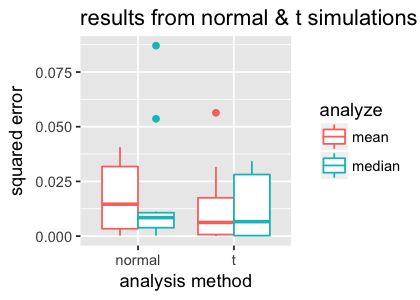

In [6]:
# Load the ggplot2 package and set up graphics within the Jupyter environment.
library(ggplot2)
library(repr)
options(repr.plot.width = 3.5,repr.plot.height = 2.5)

# Select the DSC results with the squared-error metric only, removing unusually large errors.
pdat <- subset(dscout,score == "sq_err" & score.error < 0.1)

# Create a combined violin and dotplot summarizing the accuracy of 
# the two analysis methods ("mean" and "median")
qplot(x = simulate,y = score.error,data = pdat,color = analyze,geom = "boxplot",
      xlab = "analysis method",ylab = "squared error",
      main = "results from normal & t simulations")

From this plot, we see that the median is substantially more accurate than the mean in the normal simulations, on average, and it yields only slightly worse accuracy in the normal simulations.

## Recap

This example presented in this tutorial was very simple. Despite its simplicity, we showed that:

+ A DSC experiment can be decomposed into "modules";

+ The modules can be conveniently grouped, combined and replicated;

+ The results of a DSC experiment can be quickly loaded into a data frame in R, and they can be explored using standard R tools or R packages such as ggplot2.

## Next steps

To learn more about the syntax of the DSC file so that you can develop your own DSCs, read [Part II of this Introduction to DSC](First_Course_Elaborated.html).